## Covid-19 Outbreak Analysis Italian Provinces


In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline
register_matplotlib_converters()

now = datetime.now()
print("Updated at (UTC Time):", now)

Updated at (UTC Time): 2020-04-18 17:32:43.198106


## Data of italian provinces
The data is fetched from the repository of the italian government, which is updated daily. First we remove the rows which do not contain confirmed information.

In [2]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
df = pd.read_csv(url)
df = df[df['denominazione_provincia'] != 'In fase di definizione/aggiornamento']
print(df.size)
df['date'] = pd.to_datetime(df['data'])

70620


## Data of Province Bolzano
Next we create a new Data Frame containing only the values of the province we want to analyze, namely the province of Bolzano.


In [3]:
df_bz = df[df["denominazione_provincia"] == 'Bolzano']

## Plot the average cumulative cases per province in Italy
Using the data of the provinces we can plot the average total cases of all provinces, the shaded region represents the difference between the region with the most cases and the one with the least.

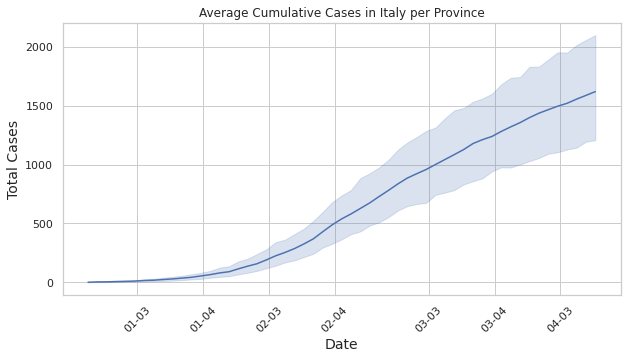

In [4]:
plt.figure(figsize=(10,5))
plot =sns.lineplot(df['date'], df['totale_casi'])
x_dates = df['date'].dt.strftime('%d-%m').sort_values().unique()
plot.set_xticklabels(x_dates, rotation=45)
plot.set_title("Average Cumulative Cases in Italy per Province")
plt.ylabel('Total Cases', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()

##  Plot the total cumulative sum of cases in Italy
Here we plot the total cases in Italy.


In [5]:
total_cases_sum = df.groupby('date')['totale_casi'].sum()

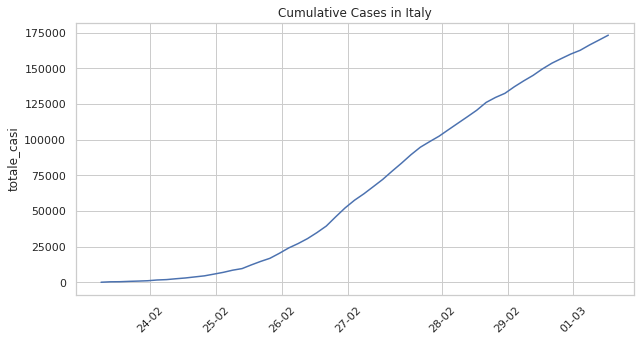

In [6]:
plt.figure(figsize=(10,5))
dates = np.array(total_cases_sum.index.to_pydatetime(), dtype=np.datetime64)
plot = sns.lineplot(dates, total_cases_sum)

x_dates = total_cases_sum.index.strftime('%d-%m')
plot.set_xticklabels(x_dates, rotation=45)
plot.set_title("Cumulative Cases in Italy")
plt.show()


## Province Bolzano 
Now we can compare the province of Bolzano to the regional average

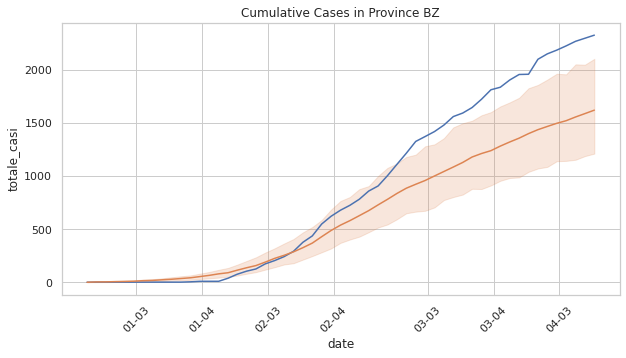

In [7]:
plt.figure(figsize=(10,5))
plot = sns.lineplot(df_bz['date'], df_bz['totale_casi'])
plot =sns.lineplot(df['date'], df['totale_casi'])

x_dates = df['date'].dt.strftime('%d-%m').sort_values().unique()
plot.set_xticklabels(x_dates, rotation=45)
plot.set_title("Cumulative Cases in Province BZ")
plt.show()


## New cases every day in Province Bolzano
One of the most important numbers, in terms of analyzing how the measures taken by the government affect the spred of the virus is the number of new cases that are registered every day.

Text(0.5, 1.0, 'New Cases Every Day in Province BZ')

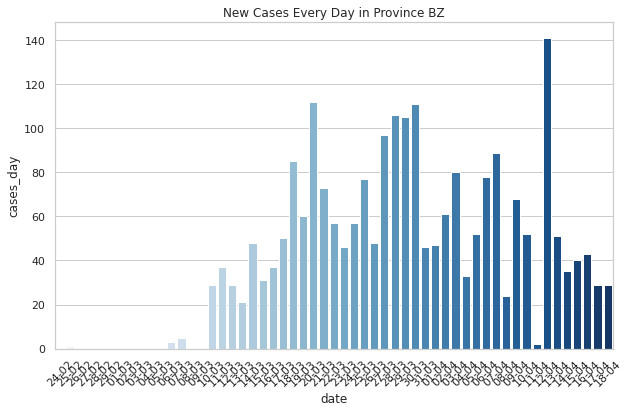

In [8]:
cases_of_day = []
cases_before = 0
for index, row in df_bz.iterrows():
    cases_of_day.append(row[9] - cases_before)
    cases_before = row[9]
df_cases = df_bz.copy()
df_cases['cases_day'] = cases_of_day
fig, ax = plt.subplots(figsize=(10,6))
plot = sns.barplot(df_cases['date'], df_cases['cases_day'], palette="Blues")
x_dates = df_cases['date'].dt.strftime('%d-%m').unique()
plot.set_xticklabels(x_dates, rotation=45)
plot.set_title("New Cases Every Day in Province BZ")

## Predicting cumulative cases in Province Bolzano
We're going to use linear regression to predict the number of deaths for the next week. The growth is exponential, therefore we create a new column with the log of the infections, which we use to predict further cases.

In [9]:

import statsmodels.api as sm
# we will predict 2 days into the future
DAY_RANGE = range(1,df_bz.shape[0] + 2)

# create new DF with total cases and augment with log_infections and days since first case
df2 = pd.DataFrame()
days = [i for i in range(df_bz.shape[0])]
df2['date'] = df_bz['date']
df2['days'] = days
df2['infections'] = df_bz['totale_casi']
df2 = df2[df2.infections > 0]
df2['log_infections'] = np.log(df2['infections'])
df2.head()

,date,days,infections,log_infections
136,2020-02-25 18:00:00,1,1,0.0
264,2020-02-26 18:00:00,2,1,0.0
392,2020-02-27 18:00:00,3,1,0.0
520,2020-02-28 18:00:00,4,1,0.0
648,2020-02-29 17:00:00,5,1,0.0


Create a model using the days sice the first case and the log of the total infected count.

In [10]:
X = df2.days
X = sm.add_constant(X)
y = df2.log_infections

In [11]:
model = sm.OLS(y, X)
res = model.fit()

We use the params of the fitted model to predict the growth:

In [12]:
a_exp = res.params.const
b_exp = res.params.days
y_pred = [np.exp(a_exp + b_exp * x) for x in DAY_RANGE]

Here we will do the same thing, but instead of fitting the model on the whole data, we will just use the past 4 days to get a recent trend of how the epidemic is evolving

In [13]:
df3 = df2[df2.days > df_bz.shape[0] - 5]
X = df3.days
X = sm.add_constant(X)
y = df3.log_infections
model = sm.OLS(y, X)
res = model.fit()

In [14]:
a = res.params.const
b = res.params.days
x_pred_last_four_days =[np.exp(a + b * x) for x in DAY_RANGE]

Same thing again, but now with just 2 days

In [15]:
df4 = df2[df2.days > df_bz.shape[0] - 5]
X = df4.days
X = sm.add_constant(X)
y = df4.log_infections
model = sm.OLS(y, X)
res = model.fit()

In [16]:
a = res.params.const
b = res.params.days
x_pred_last_two_days =[np.exp(a + b * x) for x in DAY_RANGE]


Text(0.5, 1.0, 'Cumulative Cases in Province BZ')

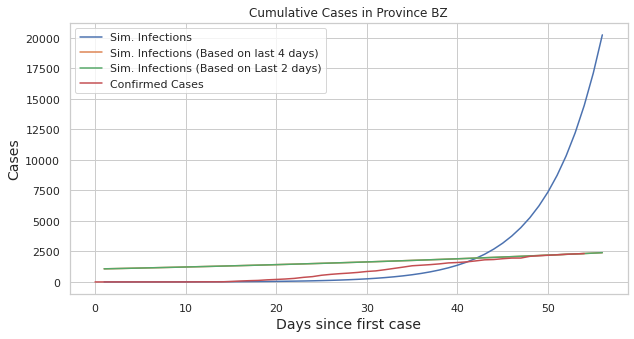

In [17]:
plt.figure(figsize=(10,5))

plot = sns.lineplot(DAY_RANGE, y_pred, label="Sim. Infections")
plot = sns.lineplot(DAY_RANGE, x_pred_last_four_days, label="Sim. Infections (Based on last 4 days)")
plot = sns.lineplot(DAY_RANGE, x_pred_last_two_days, label="Sim. Infections (Based on Last 2 days)")
plot = sns.lineplot(days, df_bz['totale_casi'], label="Confirmed Cases")

plt.ylabel('Cases', fontsize=14)
plt.xlabel('Days since first case', fontsize=14)


plot.set_title("Cumulative Cases in Province BZ")

### Fitting a logistic model

In [18]:
from scipy.optimize import curve_fit, fsolve
import datetime as dt

In [19]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [20]:
df_log = pd.read_csv(url, error_bad_lines=False)
df_log = df_log[df_log['denominazione_provincia'] == 'Bolzano']
df_log = df_log.loc[:,['data','totale_casi']]

FMT = '%Y-%m-%dT%H:%M:%S'
date = df_log['data']
df_log['day_of_year'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days )
df_log.head()

,data,totale_casi,day_of_year
8,2020-02-24T18:00:00,0,54
136,2020-02-25T18:00:00,1,55
264,2020-02-26T18:00:00,1,56
392,2020-02-27T18:00:00,1,57
520,2020-02-28T18:00:00,1,58


In [21]:
x = list(df_log.iloc[:,2])
y = list(df_log.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000], maxfev=2000)

The result gives us three values:

a: the infection speed

b: day of year with maximum new infections

c: total number of recorded infected people at the end of the epidemic

In [22]:
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
print("a=", a, " b=", b, " c=", c)

a= 6.711041234235825  b= 88.24152229779499  c= 2358.7891859318647


B will be the inflection point, i.e. the point where new infections on a day will be less than on the previous day

In [23]:
date = dt.date(2020,1,1) + dt.timedelta(int(b))
print(date)

2020-03-29


We can compute the end of the epidemic according to the model by solving the equation of the model

In [24]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
date = dt.date(2020,1,1) + dt.timedelta(sol)
print(date)

2020-05-21


### Plotting the logistic curve

Text(0.5, 1.0, 'Comparison of total infection models')

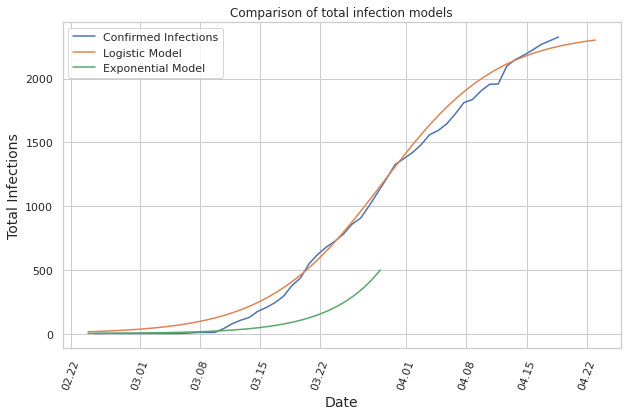

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

# logistic model
x_pred_log = [logistic_model(x,a,b,c) for x in range(54,114)]
y_pred_log = [dt.date(2020,1,1) + dt.timedelta(i) for i in range(54,114)]


# exponential model
x_pred_infections = [np.exp(a_exp + b_exp * x) for x in range(35)]
y_pred_exp = [dt.date(2020,1,1) + dt.timedelta(i) for i in range(54,89)]

plot = sns.lineplot(df_bz['date'], df_bz['totale_casi'], label="Confirmed Infections")
plot = sns.lineplot(y_pred_log, x_pred_log, label="Logistic Model")
plot = sns.lineplot(y_pred_exp, x_pred_infections, label="Exponential Model")

plt.xticks(rotation=70)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))

plt.ylabel('Total Infections', fontsize=14)
plt.xlabel('Date', fontsize=14)

plot.set_title("Comparison of total infection models")


## Learn More
[Data Source](https://github.com/pcm-dpc/COVID-19)

[WHO](https://www.who.int/)

[Ministero della Salute](http://www.salute.gov.it/nuovocoronavirus)
